Number of subplots (axes) = 6


C:\Users\louislin\AppData\Local\Temp\ipykernel_20988\2860158462.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


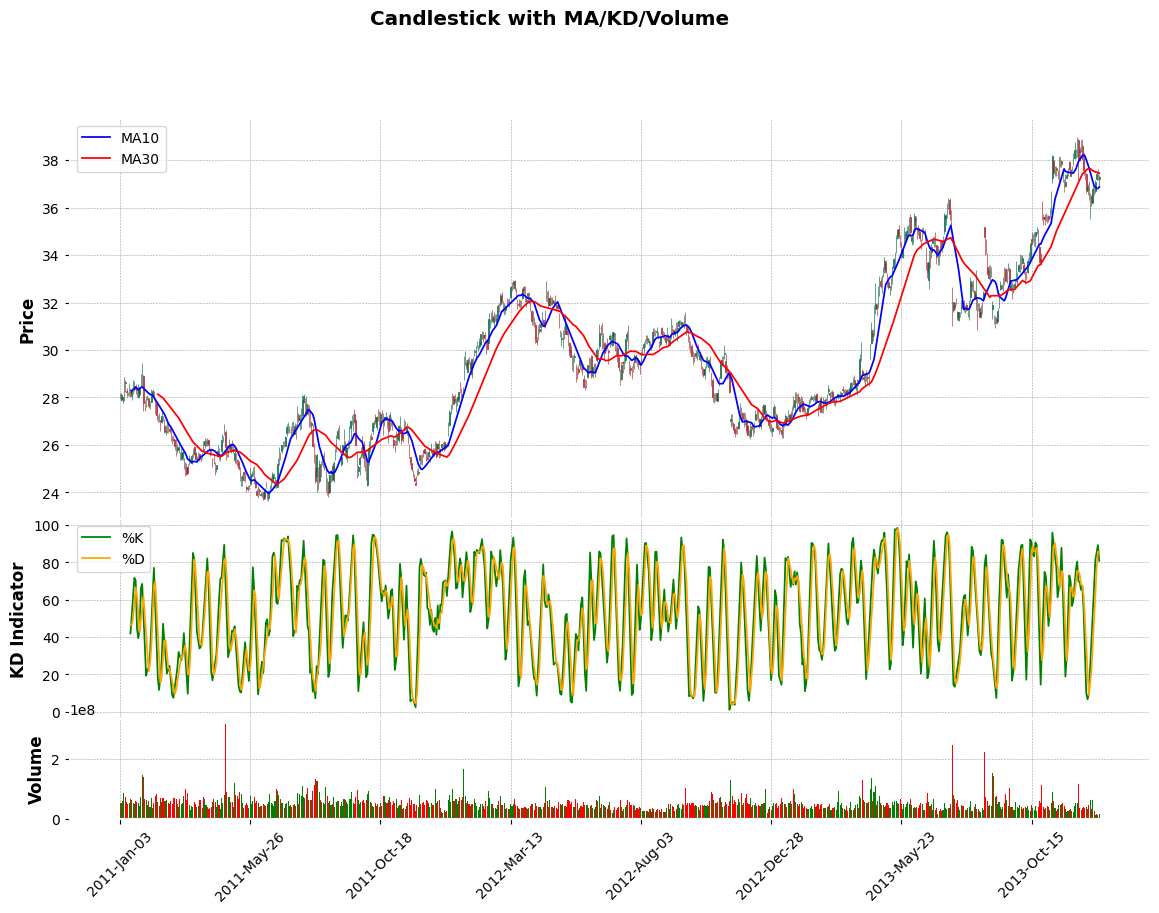

In [83]:
import pandas as pd
import talib
import mplfinance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

df = pd.read_csv("MSFT.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d', errors='coerce')
df.dropna(subset=['Date'], inplace=True)
df.set_index('Date', inplace=True)

# 移除關鍵欄位的 NaN (至少要有 Open,High,Low,Close,Volume)
df.dropna(subset=['Open','High','Low','Close','Volume'], inplace=True)

# MA, KD
df['MA10'] = talib.SMA(df['Close'], 10)
df['MA30'] = talib.SMA(df['Close'], 30)
df['slowk'], df['slowd'] = talib.STOCH(df['High'], df['Low'], df['Close'])

# 設定 Volume 顏色
volume_colors = ['green' if c >= o else 'red' for c, o in zip(df['Close'], df['Open'])]

apds = [
    mpf.make_addplot(df['MA10'], color='blue', label='MA10'),
    mpf.make_addplot(df['MA30'], color='red',  label='MA30'),
    mpf.make_addplot(df['slowk'], panel=1, color='green',  label='%K'),
    mpf.make_addplot(df['slowd'], panel=1, color='orange', label='%D'),
    mpf.make_addplot(df['Volume'], panel=2, type='bar', color=volume_colors)
]

my_style = mpf.make_mpf_style(
    base_mpf_style='charles',
    y_on_right=False
)

# 加上 warn_too_much_data=999999 可以抑制「資料過多」的警告
fig, axes = mpf.plot(
    df,
    type='candle',
    style=my_style,
    addplot=apds,
    panel_ratios=(4, 2, 1),
    volume=False,
    figsize=(15, 10),
    title='Candlestick with MA/KD/Volume',
    returnfig=True,
    warn_too_much_data=999999
)

print(f"Number of subplots (axes) = {len(axes)}")
# 若你列印會看到 6 個 axes，原因如上所述

# 依照索引對「主軸」的 subplot 設 y-label
axes[0].set_ylabel('Price')
axes[2].set_ylabel('KD Indicator')
axes[4].set_ylabel('Volume')



# 顯示主圖圖例 (MA10/MA30)
axes[0].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import talib

"""Loading Numerical Data"""
STOCK_FILE = "MSFT.csv"
price_df = pd.read_csv(STOCK_FILE)
print(price_df.info())
price_df['Date'] = pd.to_datetime(price_df['Date'], format='%Y-%m-%d', errors='coerce')
price_df.sort_values('Date', inplace=True)
price_df.set_index('Date', inplace=True)

"""Loading Context Data"""
NEWS_FILE = "MSFT_news.pkl"
news_df = pd.read_pickle(NEWS_FILE)
if isinstance(news_df, list):

    cols = ["Tickers","Date","Title","Content"]
    news_df = pd.DataFrame(news_df, columns=cols)
news_df['Date'] = pd.to_datetime(news_df['Date'], format='%Y-%m-%d', errors='coerce')
news_df.sort_values('Date', inplace=True)
news_df.set_index('Date', inplace=True)

news_df['text'] = news_df['Title'] + " " + news_df['Content']
print(news_df.info())
news_df.to_csv("MSFT_news.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 753 entries, 0 to 752
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       753 non-null    object 
 1   Open       753 non-null    float64
 2   High       753 non-null    float64
 3   Low        753 non-null    float64
 4   Close      753 non-null    float64
 5   Volume     753 non-null    int64  
 6   Adj Close  753 non-null    float64
dtypes: float64(5), int64(1), object(1)
memory usage: 41.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2444 entries, 2011-03-03 to 2013-11-22
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Tickers  2444 non-null   object
 1   Title    2444 non-null   object
 2   Content  2444 non-null   object
 3   text     2444 non-null   object
dtypes: object(4)
memory usage: 95.5+ KB
None


In [ ]:
"""Prepare Embedding Vector"""
from transformers import BertTokenizer, BertModel
import torch
import numpy as np
import os 

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

def get_embedding_token(text):
    
    inputs = tokenizer(text, 
                       return_tensors="pt", # tensor type
                       truncation=True, #截斷
                       padding=True,   # 長度不夠做padding使長度一致
                       max_length=512) # default length : 512
    """Inference output"""
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # shape: (768,)

MULTI_MODEL = True # decide wether to use mulit-modality model(include news) or only stock price

if MULTI_MODEL:
    print(f"Using files {STOCK_FILE} and {NEWS_FILE}")
    EMBEDDING_FILE = "bert_embeddings.npy"
    if not os.path.exists(EMBEDDING_FILE):
        #未存在已經embedding 過後的file
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        model = BertModel.from_pretrained("bert-base-uncased")
        embedding_vectors = []
        print(f"Embedding file :{EMBEDDING_FILE} does't exist, start embedding.")
        for text in news_df['text']:
            vec = get_embedding_token(text)
            embedding_vectors.append(vec)
        np.save(EMBEDDING_FILE, np.array(embedding_vectors))
        print(f"Embedding Down, file save to : {EMBEDDING_FILE}")
    try:
        bert_embedding = np.load('bert_embeddings.npy')
        bert_df = pd.DataFrame(bert_embedding)
        bert_df['Date'] = news_df.index
        bert_df['Date'] = pd.to_datetime(bert_df['Date'])

        #Average per Day
        daily_bert_df = bert_df.groupby('Date').mean() 
        daily_bert_df.columns = [f'bert_{i}' for i in range(768)]

        #Processing date without news
        all_dates = price_df.index.unique().sort_values()
        daily_bert_df = daily_bert_df.reindex(all_dates)
        daily_bert_df.fillna(0, inplace=True)

    except Exception as e:
        raise ValueError(f"Loading failed: {e}")
    
    df = price_df.join(daily_bert_df,how = 'inner')
else:
    print(f"Using files {STOCK_FILE}")
    df = price_df

print(df.info())
print(df.shape)

Using files MSFT.csv and MSFT_news.pkl
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 626 entries, 2011-03-03 to 2013-11-22
Columns: 774 entries, Open to bert_767
dtypes: float32(768), float64(5), int64(1)
memory usage: 1.9 MB
None
(626, 774)


In [86]:
"""Seperate Dataset"""
train_df = df.loc['2011-01-01':'2012-12-31'].copy()
val_df   = df.loc['2013-01-01':'2013-06-30'].copy()
test_df  = df.loc['2013-07-01':'2013-12-30'].copy()
print('='*30," Train ",'='*30)
print(train_df.head())
print(train_df.tail())
print('='*30," Validation ",'='*30)
print(val_df.head())
print(val_df.tail())
print('='*30," Test ",'='*30)
print(test_df.head())
print(test_df.tail())


"""Adding New Feature"""
for data in [train_df, val_df, test_df]:
    data['MA10'] = talib.SMA(data['Close'], timeperiod=10)
    data['MA30'] = talib.SMA(data['Close'], timeperiod=30)
    data['K'], data['D'] = talib.STOCH(data['High'], data['Low'], data['Close'])
    data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
    data['MACD'], data['MACD_sig'], data['MACD_hist'] = talib.MACD(data['Close'])
    data.fillna(0,inplace=True)
    print(data.head())
    print(data.info())

"""Normalization"""
if MULTI_MODEL:
    feature_cols = [
        'Open','High','Low','Close','Adj Close','Volume',
        'MA10','MA30','K','D','RSI','MACD','MACD_sig','MACD_hist'
    ] + [f'bert_{i}' for i in range(768)]
else:
    feature_cols = [
        'Open','High','Low','Close','Adj Close','Volume',
        'MA10','MA30','K','D','RSI','MACD','MACD_sig','MACD_hist'
    ]

scaler = MinMaxScaler()
scaler.fit(train_df[feature_cols])

train_scaled = scaler.transform(train_df[feature_cols])
val_scaled = scaler.transform(val_df[feature_cols])
test_scaled = scaler.transform(test_df[feature_cols])
    

==============================  Train  ==============================
             Open   High    Low  Close    Volume  Adj Close    bert_0  \
Date                                                                    
2011-03-03  26.26  26.40  26.18  26.20  68271500      20.25 -0.654505   
2011-03-04  26.22  26.24  25.80  25.95  70437200      20.06 -0.584762   
2011-03-07  26.13  26.27  25.55  25.72  64980400      19.88 -0.563111   
2011-03-08  25.77  26.02  25.65  25.91  50549800      20.03 -0.291476   
2011-03-09  25.81  25.98  25.66  25.89  39789100      20.01 -0.621309   

              bert_1    bert_2    bert_3  ...  bert_758  bert_759  bert_760  \
Date                                      ...                                 
2011-03-03  0.099405  0.157561  0.068272  ... -0.235059 -0.522852 -0.344228   
2011-03-04 -0.188609 -0.429866  0.328221  ... -0.358375 -0.511698 -0.755608   
2011-03-07  0.114492 -0.108455  0.463033  ... -0.199841 -0.592262 -0.254862   
2011-03-08 -0.029063  0

In [87]:
def create_sequences(data, seq_len=30, close_index=None):
    """
    data: 已縮放好的 numpy array (shape = [num_days, num_features])
    seq_len: 30 表示用前 30 天特徵來預測下一天
    close_index: 'Close' 欄位在 feature_cols 的 index
    """
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])            # (30, num_features)
        # 取 i+seq_len 這天的 Close (假設 feature_cols 裡面Close是 close_index)
        y.append(data[i + seq_len, close_index])
    return np.array(X), np.array(y)


close_index = feature_cols.index('Close')
print(f"Close index: {close_index}")
X_train, y_train = create_sequences(train_scaled, 30, close_index)
X_val,   y_val   = create_sequences(val_scaled,   30, close_index)
X_test,  y_test  = create_sequences(test_scaled,  30, close_index)

print(len(X_train))
print(len(y_train))

Close index: 3
385
385


In [88]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=1, mode='RNN'):
        super(RNNModel, self).__init__()
        self.mode = mode
        if mode == 'RNN':
            self.rnn = nn.RNN(input_dim, hidden_dim, num_layers, batch_first=True)
        elif mode == 'LSTM':
            self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        elif mode == 'GRU':
            self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        else:
            raise ValueError("Invalid RNN mode")
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        # x: (batch_size, seq_len, input_dim)
        out, _ = self.rnn(x)  # out: (batch_size, seq_len, hidden_dim)
        last_step = out[:, -1, :]  # 只取最後一個時間步
        return self.fc(last_step)  # shape: (batch_size, 1)


--- Training GRU | Batch=32, LR=0.001, Layers=2, Epochs=10 ---


c:\Users\louislin\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/10, Train Loss: 0.095358, Val Loss: 0.284130
Epoch 2/10, Train Loss: 0.202032, Val Loss: 0.107868
Epoch 3/10, Train Loss: 0.157762, Val Loss: 0.259446
Epoch 4/10, Train Loss: 0.091819, Val Loss: 0.205740
Epoch 5/10, Train Loss: 0.099630, Val Loss: 0.234770
Epoch 6/10, Train Loss: 0.093551, Val Loss: 0.225385
Epoch 7/10, Train Loss: 0.093018, Val Loss: 0.227791
Epoch 8/10, Train Loss: 0.092985, Val Loss: 0.226617
Epoch 9/10, Train Loss: 0.093257, Val Loss: 0.215270
Epoch 10/10, Train Loss: 0.096747, Val Loss: 0.223329


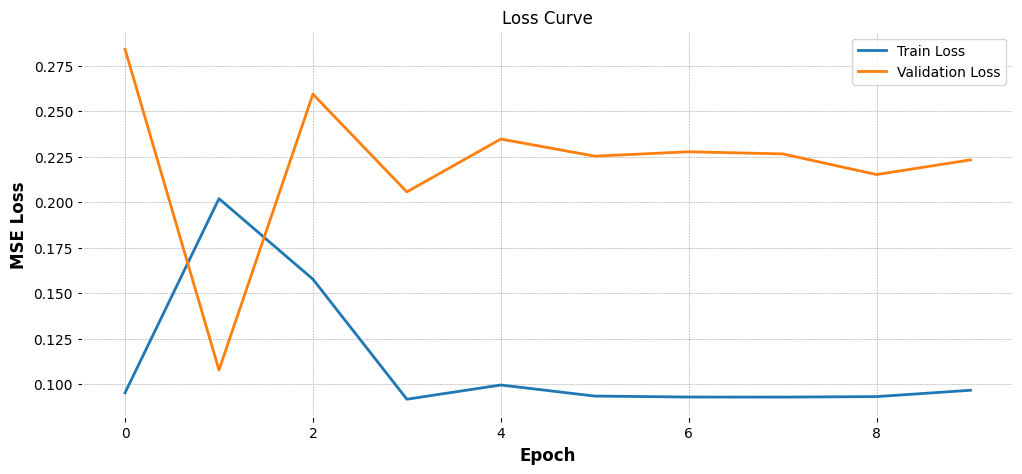


--- Training GRU | Batch=32, LR=0.001, Layers=2, Epochs=20 ---
Epoch 1/20, Train Loss: 0.158711, Val Loss: 0.122220
Epoch 2/20, Train Loss: 0.224363, Val Loss: 0.117037
Epoch 3/20, Train Loss: 0.143445, Val Loss: 0.278918
Epoch 4/20, Train Loss: 0.096590, Val Loss: 0.191847
Epoch 5/20, Train Loss: 0.103410, Val Loss: 0.230512
Epoch 6/20, Train Loss: 0.097823, Val Loss: 0.212792
Epoch 7/20, Train Loss: 0.097230, Val Loss: 0.218209
Epoch 8/20, Train Loss: 0.096277, Val Loss: 0.214355
Epoch 9/20, Train Loss: 0.094650, Val Loss: 0.216085
Epoch 10/20, Train Loss: 0.094317, Val Loss: 0.212130
Epoch 11/20, Train Loss: 0.095918, Val Loss: 0.201091
Epoch 12/20, Train Loss: 0.096571, Val Loss: 0.216799
Early stopping triggered.

--- Training GRU | Batch=32, LR=0.001, Layers=4, Epochs=10 ---
Epoch 1/10, Train Loss: 0.100294, Val Loss: 0.163492
Epoch 2/10, Train Loss: 0.194383, Val Loss: 0.180778
Epoch 3/10, Train Loss: 0.111613, Val Loss: 0.271395
Epoch 4/10, Train Loss: 0.085140, Val Loss: 0.25

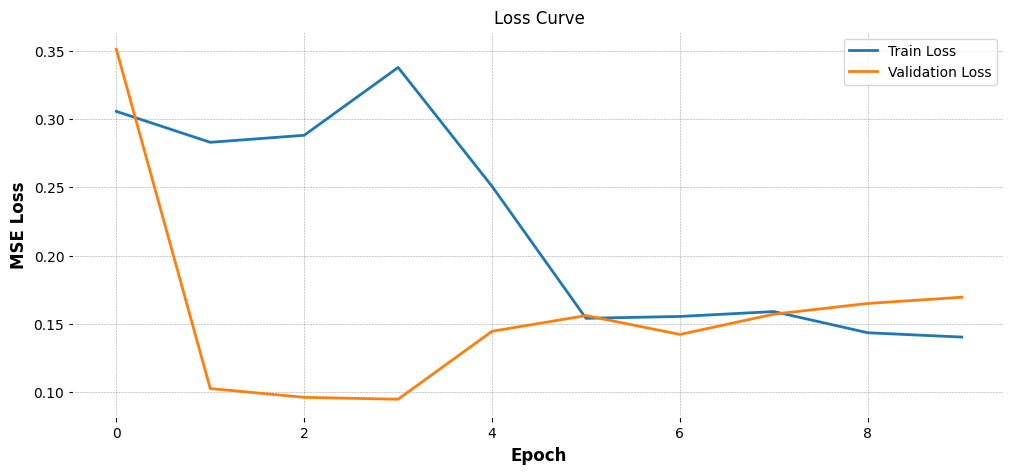


--- Training GRU | Batch=32, LR=0.01, Layers=2, Epochs=20 ---
Epoch 1/20, Train Loss: 0.197701, Val Loss: 0.606999
Epoch 2/20, Train Loss: 0.119341, Val Loss: 0.206358
Epoch 3/20, Train Loss: 0.318574, Val Loss: 0.098619
Epoch 4/20, Train Loss: 0.327928, Val Loss: 0.095253
Epoch 5/20, Train Loss: 0.245382, Val Loss: 0.131823
Epoch 6/20, Train Loss: 0.176428, Val Loss: 0.129133
Epoch 7/20, Train Loss: 0.180853, Val Loss: 0.133002
Epoch 8/20, Train Loss: 0.172467, Val Loss: 0.135977
Epoch 9/20, Train Loss: 0.169315, Val Loss: 0.144250
Epoch 10/20, Train Loss: 0.158943, Val Loss: 0.148446
Epoch 11/20, Train Loss: 0.155328, Val Loss: 0.151398
Epoch 12/20, Train Loss: 0.155486, Val Loss: 0.141915
Epoch 13/20, Train Loss: 0.161528, Val Loss: 0.140658
Epoch 14/20, Train Loss: 0.165665, Val Loss: 0.143520
Early stopping triggered.

--- Training GRU | Batch=32, LR=0.01, Layers=4, Epochs=10 ---
Epoch 1/10, Train Loss: 0.192436, Val Loss: 0.643942
Epoch 2/10, Train Loss: 0.072232, Val Loss: 0.81

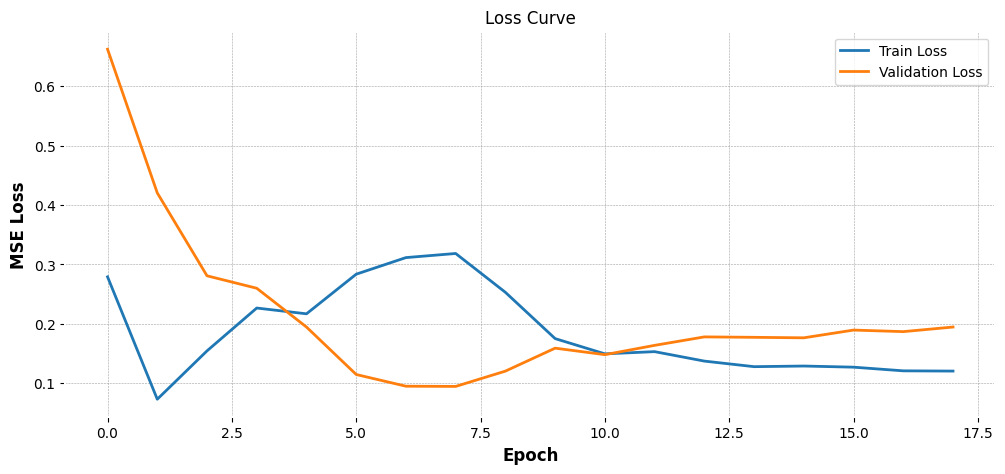


--- Training GRU | Batch=64, LR=0.001, Layers=2, Epochs=10 ---
Epoch 1/10, Train Loss: 0.245369, Val Loss: 0.101815
Epoch 2/10, Train Loss: 0.164853, Val Loss: 0.551612
Epoch 3/10, Train Loss: 0.086901, Val Loss: 0.303216
Epoch 4/10, Train Loss: 0.070013, Val Loss: 0.257909
Epoch 5/10, Train Loss: 0.079238, Val Loss: 0.356007
Epoch 6/10, Train Loss: 0.074657, Val Loss: 0.343546
Epoch 7/10, Train Loss: 0.067135, Val Loss: 0.297186
Epoch 8/10, Train Loss: 0.069790, Val Loss: 0.313661
Epoch 9/10, Train Loss: 0.069976, Val Loss: 0.320084
Epoch 10/10, Train Loss: 0.066657, Val Loss: 0.297099

--- Training GRU | Batch=64, LR=0.001, Layers=2, Epochs=20 ---
Epoch 1/20, Train Loss: 0.105908, Val Loss: 0.175985
Epoch 2/20, Train Loss: 0.147134, Val Loss: 0.355510
Epoch 3/20, Train Loss: 0.062628, Val Loss: 0.213455
Epoch 4/20, Train Loss: 0.084311, Val Loss: 0.323562
Epoch 5/20, Train Loss: 0.068702, Val Loss: 0.254448
Epoch 6/20, Train Loss: 0.065347, Val Loss: 0.253352
Epoch 7/20, Train Loss:

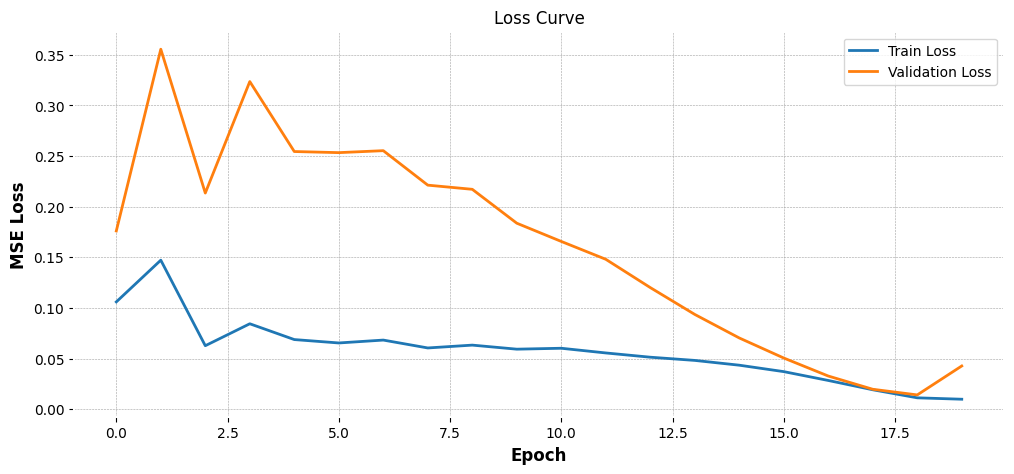


--- Training GRU | Batch=64, LR=0.001, Layers=4, Epochs=10 ---
Epoch 1/10, Train Loss: 0.093071, Val Loss: 0.170845
Epoch 2/10, Train Loss: 0.141484, Val Loss: 0.422246
Epoch 3/10, Train Loss: 0.068559, Val Loss: 0.274326
Epoch 4/10, Train Loss: 0.076888, Val Loss: 0.326089
Epoch 5/10, Train Loss: 0.076110, Val Loss: 0.353643
Epoch 6/10, Train Loss: 0.069804, Val Loss: 0.322779
Epoch 7/10, Train Loss: 0.069551, Val Loss: 0.322047
Epoch 8/10, Train Loss: 0.070240, Val Loss: 0.335782
Epoch 9/10, Train Loss: 0.068876, Val Loss: 0.331998
Epoch 10/10, Train Loss: 0.067647, Val Loss: 0.323025

--- Training GRU | Batch=64, LR=0.001, Layers=4, Epochs=20 ---
Epoch 1/20, Train Loss: 0.096333, Val Loss: 0.169132
Epoch 2/20, Train Loss: 0.139804, Val Loss: 0.482126
Epoch 3/20, Train Loss: 0.069590, Val Loss: 0.285821
Epoch 4/20, Train Loss: 0.073269, Val Loss: 0.309145
Epoch 5/20, Train Loss: 0.074901, Val Loss: 0.366829
Epoch 6/20, Train Loss: 0.070526, Val Loss: 0.352971
Epoch 7/20, Train Loss:

In [89]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch
import copy

def plot_losses_curve(train_losses,val_losses):
    plt.figure(figsize=(12, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()

"""Model Training"""
def to_tensor(x, y):
    return TensorDataset(torch.tensor(x, dtype=torch.float32),
                         torch.tensor(y, dtype=torch.float32))

MODEL = "GRU"
params_dict = {
    "batch_size": [32,64],
    "lr": [0.001, 0.01],
    "num_layers": [2,4],
    "epoch": [10, 20]
}

# Track global best model
global_best_val_loss = float('inf')
global_best_model_state = None
global_best_config = None

for batch_size in params_dict['batch_size']:
    for lr in params_dict['lr']:
        for num_layers in params_dict['num_layers']:
            for n_epochs in params_dict['epoch']:

                print(f"\n--- Training {MODEL} | Batch={batch_size}, LR={lr}, Layers={num_layers}, Epochs={n_epochs} ---")

                """Prepare datasets"""
                train_loader = DataLoader(to_tensor(X_train, y_train), batch_size=batch_size,shuffle=False)
                val_loader = DataLoader(to_tensor(X_val, y_val), batch_size=batch_size,shuffle=False)
                test_loader = DataLoader(to_tensor(X_test, y_test), batch_size=batch_size,shuffle=False)

                """Prepare Training"""
                input_dim = X_train.shape[2]
                hidden_dim = 64
                model = RNNModel(input_dim, hidden_dim, num_layers, MODEL)
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                """Evolution Parameters"""
                train_losses = []
                val_losses = []

                """Early Stopping"""
                early_stopping_patience = 10
                best_val_loss = float('inf')
                patience_counter = 0

                """Start Training"""
                for epoch in range(n_epochs):
                    model.train()
                    train_loss = 0.0
                    for xb, yb in train_loader:
                        pred = model(xb).squeeze()
                        loss = criterion(pred, yb)
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        train_loss += loss.item()

                    avg_train_loss = train_loss / len(train_loader)
                    train_losses.append(avg_train_loss)

                    # validation loss
                    model.eval()
                    val_loss = 0.0
                    with torch.no_grad():
                        for xb, yb in val_loader:
                            pred = model(xb).squeeze()
                            loss = criterion(pred, yb)
                            val_loss += loss.item()
                    avg_val_loss = val_loss / len(val_loader)
                    val_losses.append(avg_val_loss)

                    print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

                    # Early stopping check
                    if avg_val_loss < best_val_loss:
                        best_val_loss = avg_val_loss
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= early_stopping_patience:
                            print("Early stopping triggered.")
                            break

                # Global best model check
                if best_val_loss < global_best_val_loss:
                    global_best_val_loss = best_val_loss
                    global_best_model_state = copy.deepcopy(model.state_dict())
                    plot_losses_curve(train_losses,val_losses)
                    global_best_config = {
                        'batch_size': batch_size,
                        'lr': lr,
                        'num_layers': num_layers,
                        'epochs': n_epochs
                    }

# Save only the best model from all combinations
if global_best_model_state is not None:
    torch.save(global_best_model_state, f"best_{MODEL}_overall.pth")
    print(f"\nSaved best overall model as best_{MODEL}_overall.pth")
    print("Best config:", global_best_config)
    print("Best validation loss:", global_best_val_loss)


Test MAE: 2.1930, RMSE: 6.6157


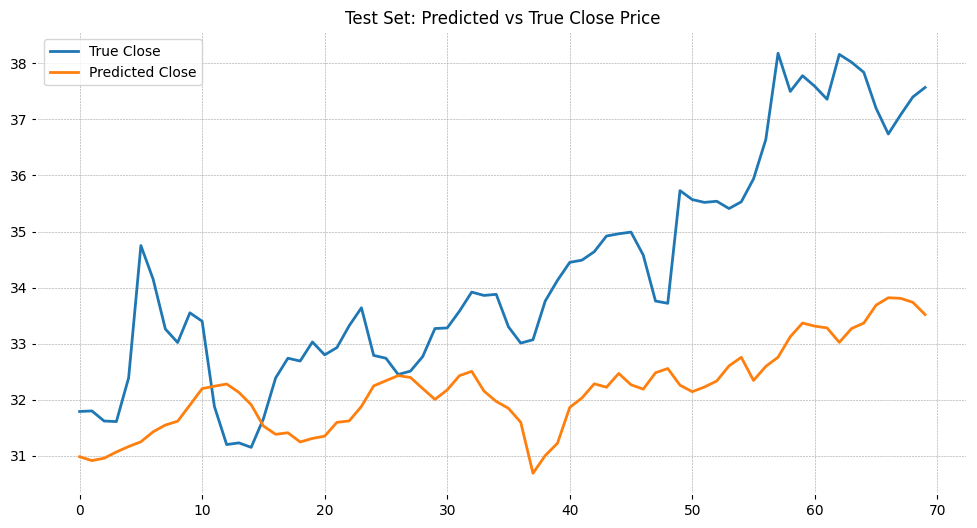

In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Reload best model for evaluation
input_dim = X_train.shape[2]
hidden_dim = 64
best_model = RNNModel(input_dim, hidden_dim, global_best_config['num_layers'], MODEL)
best_model.load_state_dict(torch.load(f"best_{MODEL}_overall.pth"))
best_model.eval()

# Evaluate on test set
# Evaluate on test set
predictions = []
actuals = []
with torch.no_grad():
    for xb, yb in DataLoader(to_tensor(X_test, y_test), batch_size=global_best_config['batch_size']):
        pred = best_model(xb)
        if pred.ndim == 1:
            predictions.extend(pred.tolist())
        else:
            predictions.extend(pred.squeeze(-1).tolist())
        actuals.extend(yb.tolist())

# Inverse transform
close_index = feature_cols.index('Close')
min_close = scaler.data_min_[close_index]
max_close = scaler.data_max_[close_index]
inverse = lambda z: z * (max_close - min_close) + min_close
predicted_close = [inverse(p) for p in predictions]
true_close = [inverse(a) for a in actuals]

# Evaluation metrics
mae = mean_absolute_error(true_close, predicted_close)
rmse = mean_squared_error(true_close, predicted_close)
print(f"Test MAE: {mae:.4f}, RMSE: {rmse:.4f}")

# Plot prediction result
plt.figure(figsize=(12, 6))
plt.plot(true_close, label='True Close')
plt.plot(predicted_close, label='Predicted Close')
plt.legend()
plt.title('Test Set: Predicted vs True Close Price')
plt.show()